# DIS optical flow on horizontal cell motion
Timothy Tyree<br>
Rappel Group<br>
3.3.2020<br>

In [2]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pims, tifffile
from skimage.filters import scharr_h, scharr_v, gaussian
import random as rand

#serial parallelization tools
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

#import tkinter for simple gui
from tkinter import filedialog, Tk, Canvas, PhotoImage 
from PIL import ImageTk,Image 

#automate the boring stuff
import time, os, sys, re
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
print('notebook is at: ' + nb_dir)

notebook is at: /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/nb


# step 1: tune a custom optical flow routine

## step 1.a: import and preprocess your data

In [3]:
#setup user interface for file selection
def search_for_file_path (currdir = os.getcwd()):
    root = Tk()
    tempdir = filedialog.askopenfilename(parent=root,initialdir=currdir, title="Please select desired file.")                                
    root.destroy()
    if len(tempdir) > 0: print ("Frames: %s" % tempdir)
    return tempdir

In [4]:
data_file_name = search_for_file_path()

Frames: /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/aravind's 1D data/pos1234_C0.tif


In [5]:
assert(os.path.exists(data_file_name))

In [6]:
#import data as grayscale
@pims.pipeline
def gray(image):
    return np.uint8(image[:, :, 0])  # Take just the red channel
frames = pims.TiffStack_libtiff(data_file_name)

shape of first frame is (492, 1716).
datatype of first frame is uint16.
max value = 65503.
min value = 13282.


Frame([[48148, 51390, 52516, ..., 44161, 44656, 38068],
       [47371, 48859, 50603, ..., 47669, 47256, 44664],
       [49016, 49652, 51797, ..., 48472, 48044, 44464],
       ...,
       [32621, 30196, 38580, ..., 41406, 40529, 41928],
       [32494, 29646, 37959, ..., 43416, 42075, 41213],
       [32846, 29153, 38565, ..., 41882, 42013, 39944]], dtype=uint16)
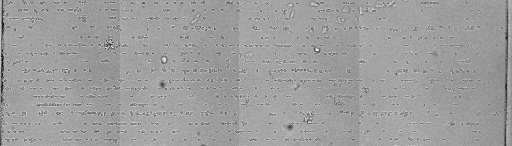

In [7]:
frame = frames[0]# plt.imshow(frame, cmap='gray')
print(f'shape of first frame is {frame.shape}.\ndatatype of first frame is {frame.dtype}.')
print(f'max value = {np.max(frame)}.\nmin value = {np.min(frame)}.')
frame

In [8]:
def preprocess(frames, thresh=90):
    '''frames is an iterable of numpy.array objects. 
    uses scharr filter to get cell edges from DIC channel, 
    scaling down to uint8 dtypes.
    returns a stack of image list of frames. 
    preprocessing should be done with this output 
    to avoid normalizing intensity with respect 
    to variable empirical parameters.'''
    md1 = np.median(frames[0])
    mx1 = np.max(frames[0])#nearly 65535 for uint16
    md2 = np.median(frames[-1])
    mx2 = np.max(frames[-1])
    md  = md1/2+md2/2
    mx  = mx1/2+mx2/2
    def processInput(img):
        fno  = img.frame_no
        img = 255/(mx-md)*(img-md)
        edges = np.sqrt(scharr_h(img)**2+scharr_v(img)**2)
        return pims.Frame(np.uint8(edges), frame_no=fno+1)
    start = time.time()
    inputs = frames
    edges = Parallel(n_jobs=num_cores, verbose=.1)(delayed(processInput)(img) for img in inputs)
    end = time.time()
    print('{} seconds elapsed taking scharr filtration.'.format(np.around(end-start,1)))
    #denoise the background of the scharr transform with a lower bound threshold edge intensity
    imgs = edges.copy()
    for img in imgs:
        img[img<thresh] = 0
        img[img>thresh] = 255
    return imgs

In [13]:
# plt.imshow(frame-np.median(frame))
edges = preprocess(frames, thresh = 90)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 203 out of 203 | elapsed:    2.3s finished


2.3 seconds elapsed taking scharr filtration.


shape of first frame is (492, 1716).
datatype of first frame is uint8.
max value = 255.
min value = 0.


Frame([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
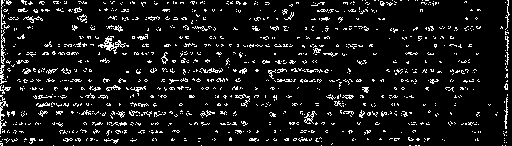

In [14]:
frame = edges[0]
# plt.imshow(frame, cmap='gray')
print(f'shape of first frame is {frame.shape}.\ndatatype of first frame is {frame.dtype}.')
print(f'max value = {np.max(frame)}.\nmin value = {np.min(frame)}.')
frame

## step 1.b: calculate flow between two frames and export results

In [15]:
#initialize DIS optical flow
dis = cv.cv2.DISOpticalFlow_create(cv.cv2.DISOpticalFlow_PRESET_MEDIUM)

In [16]:
dis.calc?

In [28]:
# edges[1]

In [19]:
#calculate flow
prv  = edges[0]
nxt  = edges[1]
img_flow = dis.calc(prv,nxt, flow=None)
# pims.Frame(img_flow)

In [29]:
#take x, y components
flow_x = img_flow[...,0]
flow_y = -img_flow[...,1]

In [21]:
#look at numerical values of x,y flow
print(f"for flow_x, mean±std = {np.mean(flow_x):.2f}±{np.std(flow_x):.2f}.")
print(f"for flow_y, mean±std = {np.mean(flow_y):.2f}±{np.std(flow_y):.2f}.")

for flow_x, mean±std = -0.06±0.40.
for flow_y, mean±std = 0.22±0.41.


Frame([[ 0.12198421,  0.12241158,  0.12326632, ..., -0.10295957,
        -0.10475014, -0.10564542],
       [ 0.12179438,  0.12222807,  0.12309547, ..., -0.10296461,
        -0.10476881, -0.10567091],
       [ 0.12141472,  0.12186106,  0.12275376, ..., -0.10297467,
        -0.10480615, -0.10572189],
       ...,
       [-0.35240304, -0.35248113, -0.3526373 , ..., -0.10773873,
        -0.10770935, -0.10769466],
       [-0.35392466, -0.35388848, -0.35381618, ..., -0.10771568,
        -0.10780054, -0.10784297],
       [-0.3546855 , -0.35459217, -0.35440564, ..., -0.10770416,
        -0.10784614, -0.10791713]], dtype=float32)
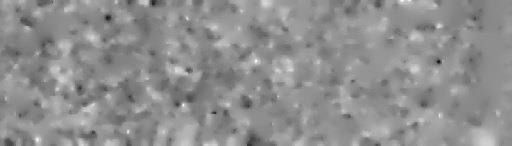

In [30]:
pims.Frame(flow_x)

In [31]:
#separate left/right flow
flow_right = flow_x.copy()
flow_right[flow_right<=0] = 0
flow_left = -flow_x.copy()
flow_left[flow_left<=0] = 0

Frame([[0.12198421, 0.12241158, 0.12326632, ..., 0.        , 0.        ,
        0.        ],
       [0.12179438, 0.12222807, 0.12309547, ..., 0.        , 0.        ,
        0.        ],
       [0.12141472, 0.12186106, 0.12275376, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)
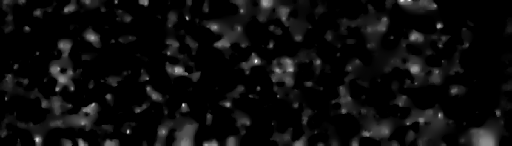

In [32]:
pims.Frame(flow_right)

Frame([[0.        , 0.        , 0.        , ..., 0.10295957, 0.10475014,
        0.10564542],
       [0.        , 0.        , 0.        , ..., 0.10296461, 0.10476881,
        0.10567091],
       [0.        , 0.        , 0.        , ..., 0.10297467, 0.10480615,
        0.10572189],
       ...,
       [0.35240304, 0.35248113, 0.3526373 , ..., 0.10773873, 0.10770935,
        0.10769466],
       [0.35392466, 0.35388848, 0.35381618, ..., 0.10771568, 0.10780054,
        0.10784297],
       [0.3546855 , 0.35459217, 0.35440564, ..., 0.10770416, 0.10784614,
        0.10791713]], dtype=float32)
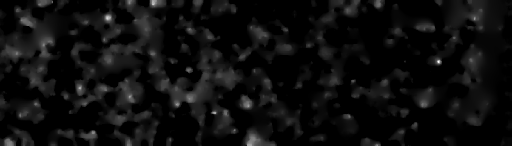

In [33]:
pims.Frame(flow_left)

[[0.04380375 0.07420163 0.11503281 ... 0.01886946 0.01797017 0.01627964]
 [0.05529697 0.0940552  0.14642997 ... 0.02087405 0.01937396 0.0173477 ]
 [0.06485936 0.1108439  0.1734135  ... 0.02117428 0.01890867 0.01662336]
 ...
 [0.23581916 0.29960884 0.35566482 ... 0.         0.         0.        ]
 [0.19667357 0.25160142 0.30081681 ... 0.         0.         0.        ]
 [0.15293906 0.19690025 0.23694611 ... 0.         0.         0.        ]]


Frame([[0.04380375, 0.07420163, 0.11503281, ..., 0.01886946, 0.01797017,
        0.01627964],
       [0.05529697, 0.0940552 , 0.14642997, ..., 0.02087405, 0.01937396,
        0.0173477 ],
       [0.06485936, 0.1108439 , 0.1734135 , ..., 0.02117428, 0.01890867,
        0.01662336],
       ...,
       [0.23581916, 0.29960884, 0.35566482, ..., 0.        , 0.        ,
        0.        ],
       [0.19667357, 0.25160142, 0.30081681, ..., 0.        , 0.        ,
        0.        ],
       [0.15293906, 0.19690025, 0.23694611, ..., 0.        , 0.        ,
        0.        ]])
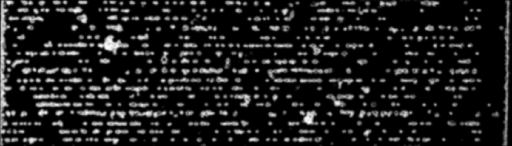

In [34]:
#constrain flow to cell area
cell_area = gaussian(nxt+prv, sigma=3)
print(cell_area)
pims.Frame(cell_area)

In [35]:
#binarize cell area
threshold = 0.1
cell_area[cell_area>threshold]  = 1
cell_area[cell_area<=threshold] = 0

Frame([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])
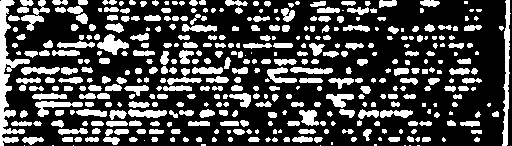

In [36]:
pims.Frame(cell_area)

Frame([[0.        , 0.        , 0.12326632, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.12309547, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.12186106, 0.12275376, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])
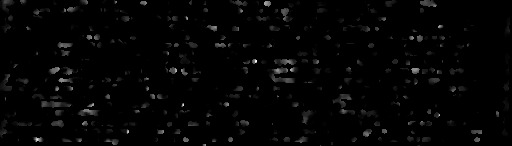

In [37]:
pims.Frame(cell_area*flow_right)

Frame([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.35240304, 0.35248113, 0.35263729, ..., 0.        , 0.        ,
        0.        ],
       [0.35392466, 0.35388848, 0.35381618, ..., 0.        , 0.        ,
        0.        ],
       [0.35468549, 0.35459217, 0.35440564, ..., 0.        , 0.        ,
        0.        ]])
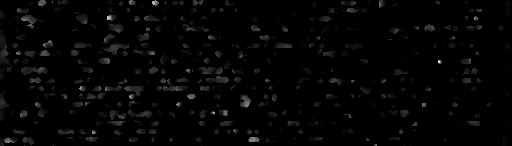

In [38]:
pims.Frame(cell_area*flow_left)

In [40]:
#select flow only where there are cells
flow_left_cells  = (cell_area*flow_left)
flow_right_cells = (cell_area*flow_right)

#compress data type (optional, but reccomended)
flow_left_cells   = flow_left_cells.astype('float16')
flow_right_cells  = flow_right_cells.astype('float16')
cell_area_cells   = cell_area.astype('float16')

#look at numerical values of x,y flow
print(f"for right flow, mean±std = {np.mean(flow_right_cells):.2f}±{np.std(flow_right_cells):.2f}.")
print(f"for right flow, (max,min) = ({np.max(flow_right_cells):.2f}, {np.min(flow_right_cells):.2f}).\n")
print(f"for left flow,  mean±std = {np.mean(flow_left_cells):.2f}±{np.std(flow_left_cells):.2f}.")
print(f"for left flow, (max,min) = ({np.max(flow_left_cells):.2f}, {np.min(flow_left_cells):.2f}).")

for right flow, mean±std = 0.04±0.16.
for right flow, (max,min) = (2.44, 0.00).

for left flow,  mean±std = 0.06±0.19.
for left flow, (max,min) = (3.26, 0.00).


In [41]:
#put it all in a texture
raw_frame = frames[1].astype('float16')
output_texture = np.stack([flow_left_cells, flow_right_cells, cell_area_cells, raw_frame], axis=-1)

the output has shape (492, 1716, 4) and data type float16.
the max value of  left flow is 3.26 while the min value of  left flow is 0.00.
the max value of right flow is 2.44 while the min value of right flow is 0.00.


Frame([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9152e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9056e+04],
        [0.0000e+00, 1.2329e-01, 1.0000e+00, 5.1232e+04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3968e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1984e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6320e+04]],

       [[0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8992e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 5.2064e+04],
        [0.0000e+00, 1.2311e-01, 1.0000e+00, 5.1712e+04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7488e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8096e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.4160e+04]],

       [[0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8320e+04],
        [0.0000e+00, 1.2189e-01, 1.0000e+00, 5.0240e+04],
        [0.0000e+00, 1.2274e-01, 1.0000e+00, 5.0240e+04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8192e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8192e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.4288e+04]],

       ...,

       [[3.5229e-01, 0.0000e+00, 1.0000e+00, 3.0352e+04],
        [3.5254e-01, 0.0000e+00, 1.0000e+00, 2.8368e+04],
        [3.5254e-01, 0.0000e+00, 1.0000e+00, 3.7568e+04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0832e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2400e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0096e+04]],

       [[3.5400e-01, 0.0000e+00, 1.0000e+00, 2.9632e+04],
        [3.5400e-01, 0.0000e+00, 1.0000e+00, 2.7376e+04],
        [3.5376e-01, 0.0000e+00, 1.0000e+00, 3.8304e+04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0672e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9904e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2048e+04]],

       [[3.5474e-01, 0.0000e+00, 1.0000e+00, 3.1312e+04],
        [3.5449e-01, 0.0000e+00, 1.0000e+00, 2.7136e+04],
        [3.5449e-01, 0.0000e+00, 1.0000e+00, 4.1728e+04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1600e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3648e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1760e+04]]], dtype=float16)
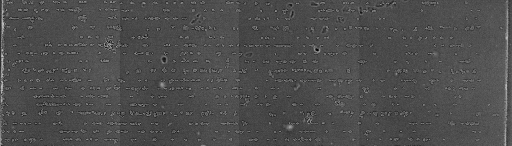

In [42]:
#look at the example output
print(f"the output has shape {output_texture.shape} and data type {output_texture.dtype}.")
print(f"the max value of  left flow is {np.max(output_texture[...,0]):.2f} while the min value of  left flow is {np.min(output_texture[...,0]):.2f}.")
print(f"the max value of right flow is {np.max(output_texture[...,1]):.2f} while the min value of right flow is {np.min(output_texture[...,1]):.2f}.")
pims.Frame(output_texture)


In [43]:
#define where to save
os.chdir(os.path.dirname(data_file_name))
save_file_name = os.path.basename(data_file_name).replace('.tif', '_output.tif')
print(f"We're going to save in {save_file_name}, which is in {os.getcwd()}.")

We're going to save in pos1234_C0_output.tif, which is in /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/aravind's 1D data.


In [44]:
#save example output 
save_params = {'append':'True', 'imagej':False, 'contiguous':True}
tifffile.imsave(save_file_name, output_texture, output_texture.shape, **save_params)
#Now, look at the output.  Does it all look reasonable?

# step 2: use ^that routine to calculate flow for all frames and save as a .tif

In [59]:
#put all of step 1.b together into a function that takes two frames and returns the output texture
def calculate_output_texture(prv, nxt, raw_frame):
    #calculate DIS optical flow
    dis = cv.cv2.DISOpticalFlow_create(cv.cv2.DISOpticalFlow_PRESET_MEDIUM)
    img_flow = dis.calc(prv,nxt, flow=None)
    flow_x = img_flow[...,0]
    flow_right = flow_x.copy()
    flow_right[flow_right<=0] = 0
    flow_left = -flow_x.copy()
    flow_left[flow_left<=0] = 0
    
    #calculate cell area
    cell_area = gaussian(nxt+prv, sigma=3)
    threshold = 0.1
    cell_area[cell_area>threshold]  = 1
    cell_area[cell_area<=threshold] = 0
    
    #select flow only where there are cells
    flow_left_cells  = (cell_area*flow_left)
    flow_right_cells = (cell_area*flow_right)

    #compress data type (optional, but reccomended)
    flow_left_cells   = flow_left_cells.astype('float16')
    flow_right_cells  = flow_right_cells.astype('float16')
    cell_area_cells   = cell_area.astype('float16')
    raw_frame         = raw_frame.astype('float16')
    output_texture    = np.stack([flow_left_cells, flow_right_cells, cell_area_cells, raw_frame], axis=-1)
    return output_texture

In [60]:
#(optional) reload raw DIC frames
@pims.pipeline
def gray(image):
    return np.uint8(image[:, :, 0])  # Take just the red channel
frames = pims.TiffStack_libtiff(data_file_name)

In [61]:
#(optional) detect edges again
edges = preprocess(frames, thresh = 90)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  44 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 203 out of 203 | elapsed:    8.0s finished


8.0 seconds elapsed taking scharr filtration.


the output has shape (492, 1716, 4), and data type float16.
the max value of  left flow is 5.25 while the min value of  left flow is 0.00.
the max value of right flow is 3.41 while the min value of right flow is 0.00.


Frame([[[0.000e+00, 0.000e+00, 0.000e+00, 4.717e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.973e+04],
        [0.000e+00, 7.332e-03, 1.000e+00, 5.328e+04],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, 4.176e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.326e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 3.859e+04]],

       [[0.000e+00, 0.000e+00, 0.000e+00, 5.021e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.998e+04],
        [0.000e+00, 7.755e-03, 1.000e+00, 5.245e+04],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, 4.822e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.800e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.490e+04]],

       [[0.000e+00, 0.000e+00, 0.000e+00, 4.710e+04],
        [0.000e+00, 7.374e-03, 1.000e+00, 5.011e+04],
        [0.000e+00, 8.606e-03, 1.000e+00, 5.120e+04],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, 4.835e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.749e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.413e+04]],

       ...,

       [[7.715e-02, 0.000e+00, 1.000e+00, 3.197e+04],
        [7.684e-02, 0.000e+00, 1.000e+00, 2.827e+04],
        [7.629e-02, 0.000e+00, 1.000e+00, 3.773e+04],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, 4.067e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.240e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.266e+04]],

       [[7.758e-02, 0.000e+00, 1.000e+00, 2.970e+04],
        [7.733e-02, 0.000e+00, 1.000e+00, 2.816e+04],
        [7.690e-02, 0.000e+00, 1.000e+00, 3.981e+04],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, 4.227e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.208e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.106e+04]],

       [[7.776e-02, 0.000e+00, 1.000e+00, 3.293e+04],
        [7.758e-02, 0.000e+00, 1.000e+00, 2.760e+04],
        [7.721e-02, 0.000e+00, 1.000e+00, 3.667e+04],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, 4.221e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.282e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.205e+04]]], dtype=float16)
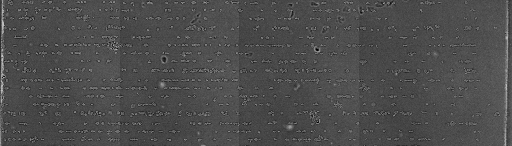

In [62]:
#test calculate_output_texture for example frame
frm = 31
raw_frame = frames[frm]
nxt = edges[frm]
prv = edges[frm-1]
output_texture = calculate_output_texture(prv=prv, nxt=nxt, raw_frame=raw_frame)

print(f"the output has shape {output_texture.shape}, and data type {output_texture.dtype}.")
print(f"the max value of  left flow is {np.max(output_texture[...,0]):.2f} while the min value of  left flow is {np.min(output_texture[...,0]):.2f}.")
print(f"the max value of right flow is {np.max(output_texture[...,1]):.2f} while the min value of right flow is {np.min(output_texture[...,1]):.2f}.")

pims.Frame(output_texture)

In [63]:
#define where to save
os.chdir(os.path.dirname(data_file_name))
save_file_name = os.path.basename(data_file_name).replace('.tif', '_output.tif')
save_params = {'append':'True', 'imagej':False, 'contiguous':True}
print(f"We're going to save in {save_file_name}, which is in {os.getcwd()}.") 

#remove the save file if it already exists
if os.path.exists(save_file_name):
    os.remove(save_file_name)

#loop over all frames (this could be parallelized)    
print('starting...')
start = time.time()
inputs = range(1,len(edges))
for frm in inputs:
    raw_frame = frames[frm]
    nxt = edges[frm]
    prv = edges[frm-1]
    output_texture = calculate_output_texture(prv=prv, nxt=nxt, raw_frame=raw_frame)
    tifffile.imsave(save_file_name, output_texture, output_texture.shape, **save_params)
end = time.time()
print('{} seconds elapsed calculating dense optical flow.'.format(np.around(end-start,1)))

We're going to save in pos1234_C0_output.tif, which is in /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/aravind's 1D data.
starting...
27.1 seconds elapsed calculating dense optical flow.


# step 3: visualize output using a movie


## step 3.a: make a custom coloring routine for an example frame

In [66]:
#load frames
frames = pims.TiffStack_libtiff(save_file_name)

Frame([[50100., 52540., 53380., ..., 42660., 41660., 41630.],
       [49200., 49300., 53200., ..., 49180., 48640., 45340.],
       [46940., 51200., 51700., ..., 47700., 47000., 45100.],
       ...,
       [29460., 25730., 36830., ..., 40930., 40100., 42370.],
       [29120., 27170., 41470., ..., 41660., 44640., 42500.],
       [32860., 30860., 43800., ..., 42780., 44580., 42240.]],
      dtype=float16)
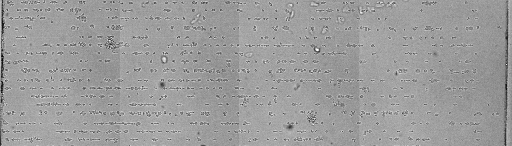

In [67]:
#view first raw DIC frame
frame = frames[10]
frame[...,3]

the max value of  left flow is 4.43359375 while the min value of  left flow is 0.0.
the max value of right flow is 2.90625 while the min value of right flow is 0.0.


Frame([[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       ...,
       [0.084  , 0.0837 , 0.083  , ..., 0.     , 0.     , 0.     ],
       [0.0837 , 0.0829 , 0.08136, ..., 0.     , 0.     , 0.     ],
       [0.0835 , 0.0825 , 0.08057, ..., 0.     , 0.     , 0.     ]],
      dtype=float16)
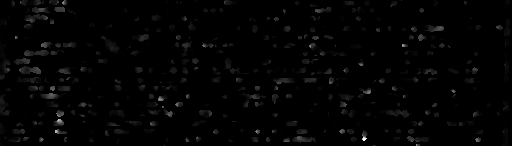

In [68]:
#view first left/right flow
print(f"the max value of  left flow is {np.max(frame[...,0])} while the min value of  left flow is {np.min(frame[...,0])}.")
print(f"the max value of right flow is {np.max(frame[...,1])} while the min value of right flow is {np.min(frame[...,1])}.")
frame[...,0]

In [51]:
#convert DIC frame to rbg image
raw_img = frame[...,3]
raw_img = pims.to_rgb(raw_img)
width, height, channel_number = raw_img.shape
print(f'this frame is {width} pixels wide, {height} pixels tall, and has {channel_number} colors.')

this frame is 492 pixels wide, 1716 pixels tall, and has 3 colors.


Frame([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 7.4453125 , 7.4453125 ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 7.45703125, 7.45703125],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 7.46875   , 7.46875   ],
        [0.        , 7.49609375, 7.49609375],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[8.3984375 , 0.        , 0.        ],
        [8.3671875 , 0.        , 0.        ],
        [8.296875  , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[8.3671875 , 0.        , 0.        ],
        [8.2890625 , 0.        , 0.        ],
        [8.1328125 , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[8.3515625 , 0.        , 0.        ],
        [8.25      , 0.        , 0.        ],
        [8.0546875 , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]])
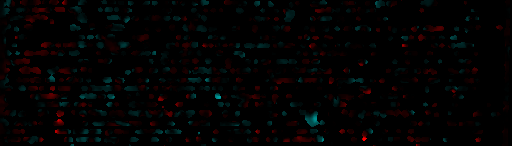

In [52]:
#define red/blue color scales
hue_scale_red  = 100
hue_scale_blue = 100

#make a red/blue filter to subtract from the raw image
left_flow    = frame[...,0]
right_flow   = frame[...,1]
filt = np.zeros([width,height,channel_number])
filt[...,0] = hue_scale_blue*left_flow#take away   red where flow is to the left
filt[...,1] = hue_scale_blue*left_flow#take away green where flow is to the left
filt[...,1] = hue_scale_red*right_flow#take away green where flow is to the right
filt[...,2] = hue_scale_red*right_flow#take away blue where flow is to the right
pims.Frame(filt)

the max value of right flow is 255 while the min value of right flow is 0.


Frame([[[178, 178, 178],
        [190, 190, 190],
        [194, 186, 186],
        ...,
        [141, 141, 141],
        [136, 136, 136],
        [136, 136, 136]],

       [[173, 173, 173],
        [174, 174, 174],
        [193, 185, 185],
        ...,
        [173, 173, 173],
        [171, 171, 171],
        [154, 154, 154]],

       [[162, 162, 162],
        [183, 175, 175],
        [186, 178, 178],
        ...,
        [166, 166, 166],
        [162, 162, 162],
        [153, 153, 153]],

       ...,

       [[ 66,  75,  75],
        [ 47,  56,  56],
        [103, 112, 112],
        ...,
        [132, 132, 132],
        [128, 128, 128],
        [139, 139, 139]],

       [[ 64,  73,  73],
        [ 55,  64,  64],
        [126, 135, 135],
        ...,
        [136, 136, 136],
        [151, 151, 151],
        [140, 140, 140]],

       [[ 83,  92,  92],
        [ 73,  82,  82],
        [138, 147, 147],
        ...,
        [141, 141, 141],
        [150, 150, 150],
        [139, 139, 139]]], dtype=uint8)
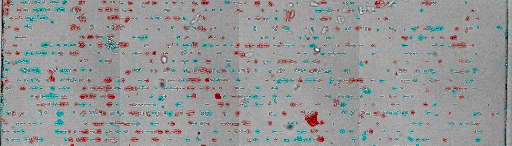

In [53]:
#color the raw image
colored_img = np.subtract(raw_img, filt)

#limit image values to 0 to 255 and compress image data type
colored_img[colored_img<0] = 0
colored_img[colored_img>255] = 255
colored_img = colored_img.astype('uint8')
print(f"the max value of right flow is {np.max(colored_img[...])} while the min value of right flow is {np.min(colored_img[...])}.")
colored_img

## step 3.b: ^that routine to color all frames and save as a .tiff

In [69]:
def color_frame(raw_img, red_img, blue_img, hue_scale_red  = 100, hue_scale_blue = 100):
    #make color filter to subtract from raw image
    raw_img = pims.to_rgb(raw_img)
    width, height, channel_number = raw_img.shape
    filt = np.zeros([width,height,channel_number])
    filt[...,0] = hue_scale_blue*blue_img#take away   red where you want blue
    filt[...,1] = hue_scale_blue*blue_img#take away green where you want blue
    filt[...,1] = hue_scale_red*red_img#take away green where you want red
    filt[...,2] = hue_scale_red*red_img#take away blue where you want red
    
    #color the raw image
    colored_img = np.subtract(raw_img, filt)

    #limit image values to 0 to 255 and compress data type of output image
    colored_img[colored_img<0] = 0
    colored_img[colored_img>255] = 255
    colored_img = colored_img.astype('uint8')
    return colored_img

Frame([[[164, 164, 164],
        [176, 176, 176],
        [156, 181, 181],
        ...,
        [149, 149, 149],
        [146, 146, 146],
        [133, 133, 133]],

       [[175, 175, 175],
        [186, 186, 186],
        [163, 188, 188],
        ...,
        [170, 170, 170],
        [171, 171, 171],
        [148, 148, 148]],

       [[170, 170, 170],
        [158, 183, 183],
        [169, 194, 194],
        ...,
        [179, 179, 179],
        [179, 179, 179],
        [155, 155, 155]],

       ...,

       [[ 56,  85,  85],
        [ 63,  92,  92],
        [130, 159, 159],
        ...,
        [134, 134, 134],
        [138, 138, 138],
        [134, 134, 134]],

       [[ 76, 104, 104],
        [ 64,  93,  93],
        [135, 164, 164],
        ...,
        [127, 127, 127],
        [145, 145, 145],
        [130, 130, 130]],

       [[ 76, 104, 104],
        [ 82, 110, 110],
        [146, 175, 175],
        ...,
        [137, 137, 137],
        [146, 146, 146],
        [144, 144, 144]]], dtype=uint8)
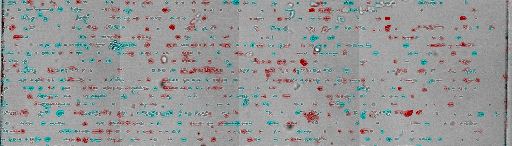

In [70]:
#test the above result for a given frame
frm   = 42
frame = frames[frm]
raw_img      = frame[...,3]
left_flow    = frame[...,0]
right_flow   = frame[...,1]
colored_img  = color_frame(raw_img = raw_img,
                          red_img  = left_flow,
                          blue_img = right_flow)
colored_img

the time averaged frame has shape (492, 1716, 4).


Frame([[[164, 164, 164],
        [176, 176, 176],
        [171, 173, 173],
        ...,
        [149, 149, 149],
        [146, 146, 146],
        [133, 133, 133]],

       [[175, 175, 175],
        [184, 186, 186],
        [178, 180, 180],
        ...,
        [170, 170, 170],
        [171, 171, 171],
        [148, 148, 148]],

       [[170, 170, 170],
        [173, 175, 175],
        [184, 186, 186],
        ...,
        [179, 179, 179],
        [179, 179, 179],
        [155, 155, 155]],

       ...,

       [[ 58,  79,  79],
        [ 65,  86,  86],
        [132, 153, 153],
        ...,
        [134, 134, 134],
        [138, 138, 138],
        [134, 134, 134]],

       [[ 77,  98,  98],
        [ 66,  87,  87],
        [137, 158, 158],
        ...,
        [127, 127, 127],
        [145, 145, 145],
        [130, 130, 130]],

       [[ 77,  98,  98],
        [ 83, 104, 104],
        [148, 169, 169],
        ...,
        [137, 137, 137],
        [146, 146, 146],
        [144, 144, 144]]], dtype=uint8)
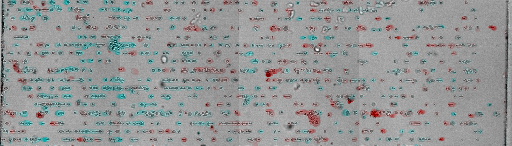

In [71]:
#(optional) time average flow 
navg  = 10 #number of frames to average over
frm   = 42
def average_image_list(img_list):
    img = np.stack(img_list[:], axis=0)
    img = np.mean(img, axis=0)
    return img
frame = frames[frm]
raw_img      = frame[...,3]
time_averaged_frame   = average_image_list(frames[frm-navg:frm])
left_flow    = time_averaged_frame[...,0]
right_flow   = time_averaged_frame[...,1]
colored_img  = color_frame(raw_img = raw_img,
                          red_img  = left_flow,
                          blue_img = right_flow, 
                          hue_scale_red = 130,
                          hue_scale_blue = 130)
print(f"the time averaged frame has shape {time_averaged_frame.shape}.")
colored_img

In [72]:
#define where to save
flow_file_name = save_file_name
os.chdir(os.path.dirname(data_file_name))
colored_file_name = flow_file_name.replace('.tif', '_colored.tiff')
save_params = {'append':'True', 'imagej':False, 'contiguous':True}
print(f"We're going to save in {save_file_name}, which is in {os.getcwd()}.") 

#load the flow data
frames = pims.TiffStack_libtiff(save_file_name)

#number of frames to average over
navg  = 5 

#remove the save file if it already exists
if os.path.exists(colored_file_name):
    os.remove(colored_file_name)

    
#loop over all frames (this could be parallelized)    
print('starting...')
start = time.time()
inputs = range(navg,len(frames))
for frm in inputs:
    frame = frames[frm]
    raw_img      = frame[...,3]
    time_averaged_frame   = average_image_list(frames[frm-navg:frm])
    left_flow    = time_averaged_frame[...,0]
    right_flow   = time_averaged_frame[...,1]
    colored_img  = color_frame(raw_img = raw_img,
                              red_img  = left_flow,
                              blue_img = right_flow, 
                              hue_scale_red = 130,
                              hue_scale_blue = 130)
    tifffile.imsave(colored_file_name, colored_img, colored_img.shape, **save_params)
end = time.time()
print('{} seconds elapsed coloring frames.'.format(np.around(end-start,1)))

We're going to save in pos1234_C0_output.tif, which is in /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/aravind's 1D data.
starting...
52.8 seconds elapsed coloring frames.


## step 3.c: convert the colored frames to a .avi movie

In [77]:
def tiffstack_to_avi(input_file_name, save_dir= None, fps=8):
    '''saves tiffstack found in the local 'path' to save_dir to a similarly named .avi file if save_dir=None.
    fps = frames per second.'''
    path = input_file_name
    if save_dir == None:
        save_dir= path[:path.find(r'.tif')]+'.avi'
    start = time.time()
    boo, cap = cv.imreadmulti(path)
    width = int(cap[0].shape[0])
    height = int(cap[0].shape[1])
    try:
        chnl_no = int(cap[0].shape[2])
    except:
        chnl_no = 0#or 1, not sure
        print('Error: depth shape not given, returning 0')
    # uncompressed YUV 4:2:0 chroma subsampled
    fourcc = cv.VideoWriter_fourcc('I','4','2','0')
    writer = cv.VideoWriter()
    retval = writer.open(save_dir, fourcc, fps, (width, height), 1)
    assert(writer.isOpened())#assert the writer is properly initialized
    for i  in range(len(cap)):
        #TODO: make this step faster by using something like the (missing) cv.GrabFrame command 
        frame = cap[i]
        writer.write(frame)
    writer.release()
    end = time.time()
    print('{} seconds elapsed reading tiffstack and writing video to avi.'.format(np.around(end-start)))
    return True

In [75]:
boo, cap = cv.imreadmulti(colored_file_name)

In [78]:
tiffstack_to_avi(colored_file_name)

1.0 seconds elapsed reading tiffstack and writing video to avi.


True

In [76]:
colored_file_name

'pos1234_C0_output_colored.tiff'

In [79]:
colored_file_name

'pos1234_C0_output_colored.tiff'

In [ ]:
#TODO: test that .avi file opens correctly.